## Waste Sorter (Working Title)


In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [8]:
from fastai.vision import *
from fastai.vision.transform import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os, shutil
import zipfile as zf
import shutil
import re
import seaborn as sns
import glob

## Extraction

In [9]:
dataset_name = "trashnet-extended"
waste_types = ['cardboard','glass','metal','paper','plastic','trash',"food"]
batch_size = 10
trained_model_path = "data"    #Leave as None if you want to retrain your model/do not have a trained model

In [45]:
# os.path.exists('data') and shutil.rmtree('data')
os.path.exists(dataset_name) and shutil.rmtree(dataset_name)
    
# files = zf.ZipFile(dataset_name+".zip",'r')
# files.extractall()
# files.close()

Split into train, valid and test

#### Run this to create the data folder:
(Skip this to use existing)

In [127]:
for subset in ['train','valid']:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))    

for waste_type in waste_types:
    fnames = {}
    filecount = 0
    for file in glob.glob(dataset_name + "/" + waste_type + "/*.jpg"):
        fnames[filecount + 1] = os.path.basename(file)
        filecount += 1
    random.seed(1)
    full_set = list(range(1,filecount+1))
    train = random.sample(full_set,int(.5*filecount)) 
    remaining = list(set(full_set)-set(train))
    valid = random.sample(remaining,int(.5*len(remaining)))
    test = list(set(remaining)-set(valid))
    
    source_folder = os.path.join(dataset_name, waste_type)
    train = [os.path.join(source_folder,fnames[i]) for i in train]
    valid = [os.path.join(source_folder,fnames[i]) for i in valid]
    test = [os.path.join(source_folder,fnames[i]) for i in test]
    
    move_files(train,"data/train/"+waste_type)
    move_files(valid,"data/valid/"+waste_type)
    move_files(test,"data/test")

In [131]:
path = Path(os.getcwd())/"data"
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",size=(512,384), resize_method=ResizeMethod.SQUISH,ds_tfms=tfms, bs=batch_size)
print(data.classes)
print(data)

['cardboard', 'food', 'glass', 'metal', 'paper', 'plastic', 'trash']
ImageDataBunch;

Train: LabelList (1300 items)
x: ImageList
Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /home/gr00t/stuff/workspaces/HB20/data;

Valid: LabelList (650 items)
x: ImageList
Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /home/gr00t/stuff/workspaces/HB20/data;

Test: LabelList (654 items)
x: ImageList
Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384)
y: EmptyLabelList
,,,,
Path: /home/gr00t/stuff/workspaces/HB20/data


## Model training

#### If you have a trained model, run this and skip to classification:

In [10]:
if trained_model_path is not None:
    model_learner = load_learner(trained_model_path)

#### Otherwise, train the model:

In [162]:
model_learner = cnn_learner(data,models.resnet50,metrics=error_rate, callback_fns=ShowGraph)
model_learner.model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/gr00t/.cache/torch/checkpoints/resnet50-19c8e357.pth


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### Finding a learning rate - Jeremy Jordan's [post](https://www.jeremyjordan.me/nn-learning-rate/)

In [ ]:
model_learner.lr_find(start_lr=1e-6,end_lr=1e1)
model_learner.recorder.plot()

The learning rate finder suggests a learning rate of 5.13e-03. With this, we can train the model.

### Training

In [58]:
model_learner.fit_one_cycle(20,max_lr=5.13e-03,callbacks=[SaveModelCallback(learn, every='epoch', monitor='error_rate')
                                                          
learn.recorder.plot_losses()

In [60]:
model_learner.export()
model_learner.path

PosixPath('/home/gr00t/stuff/workspaces/HB20/data')

### VIsualizing most incorrect images

In [11]:
interpolation_data = ClassificationInterpretation.from_learner(model_learner)
losses,idxs = interpolation_data.top_losses()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/home/gr00t/stuff/workspaces/HB20/env/lib/python3.6/site-packages/fastai/data_block.py", line 75, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


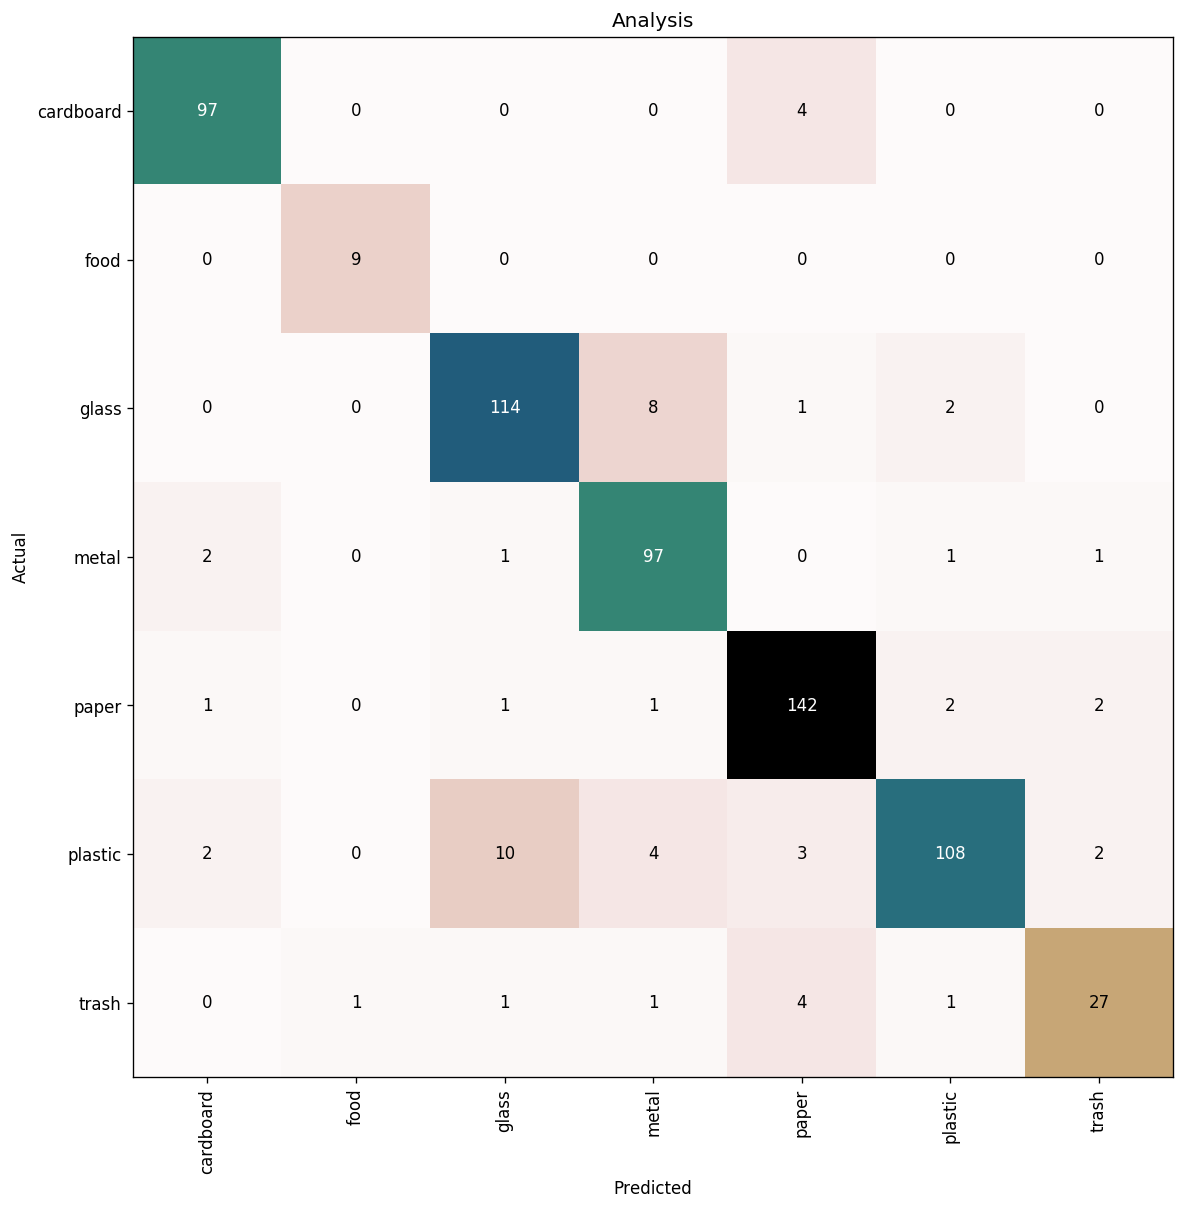

In [154]:
doc(interpolation_data.plot_top_losses)
interpolation_data.plot_confusion_matrix(title="Analysis", cmap='gist_earth_r', figsize=(10,10), dpi=60)

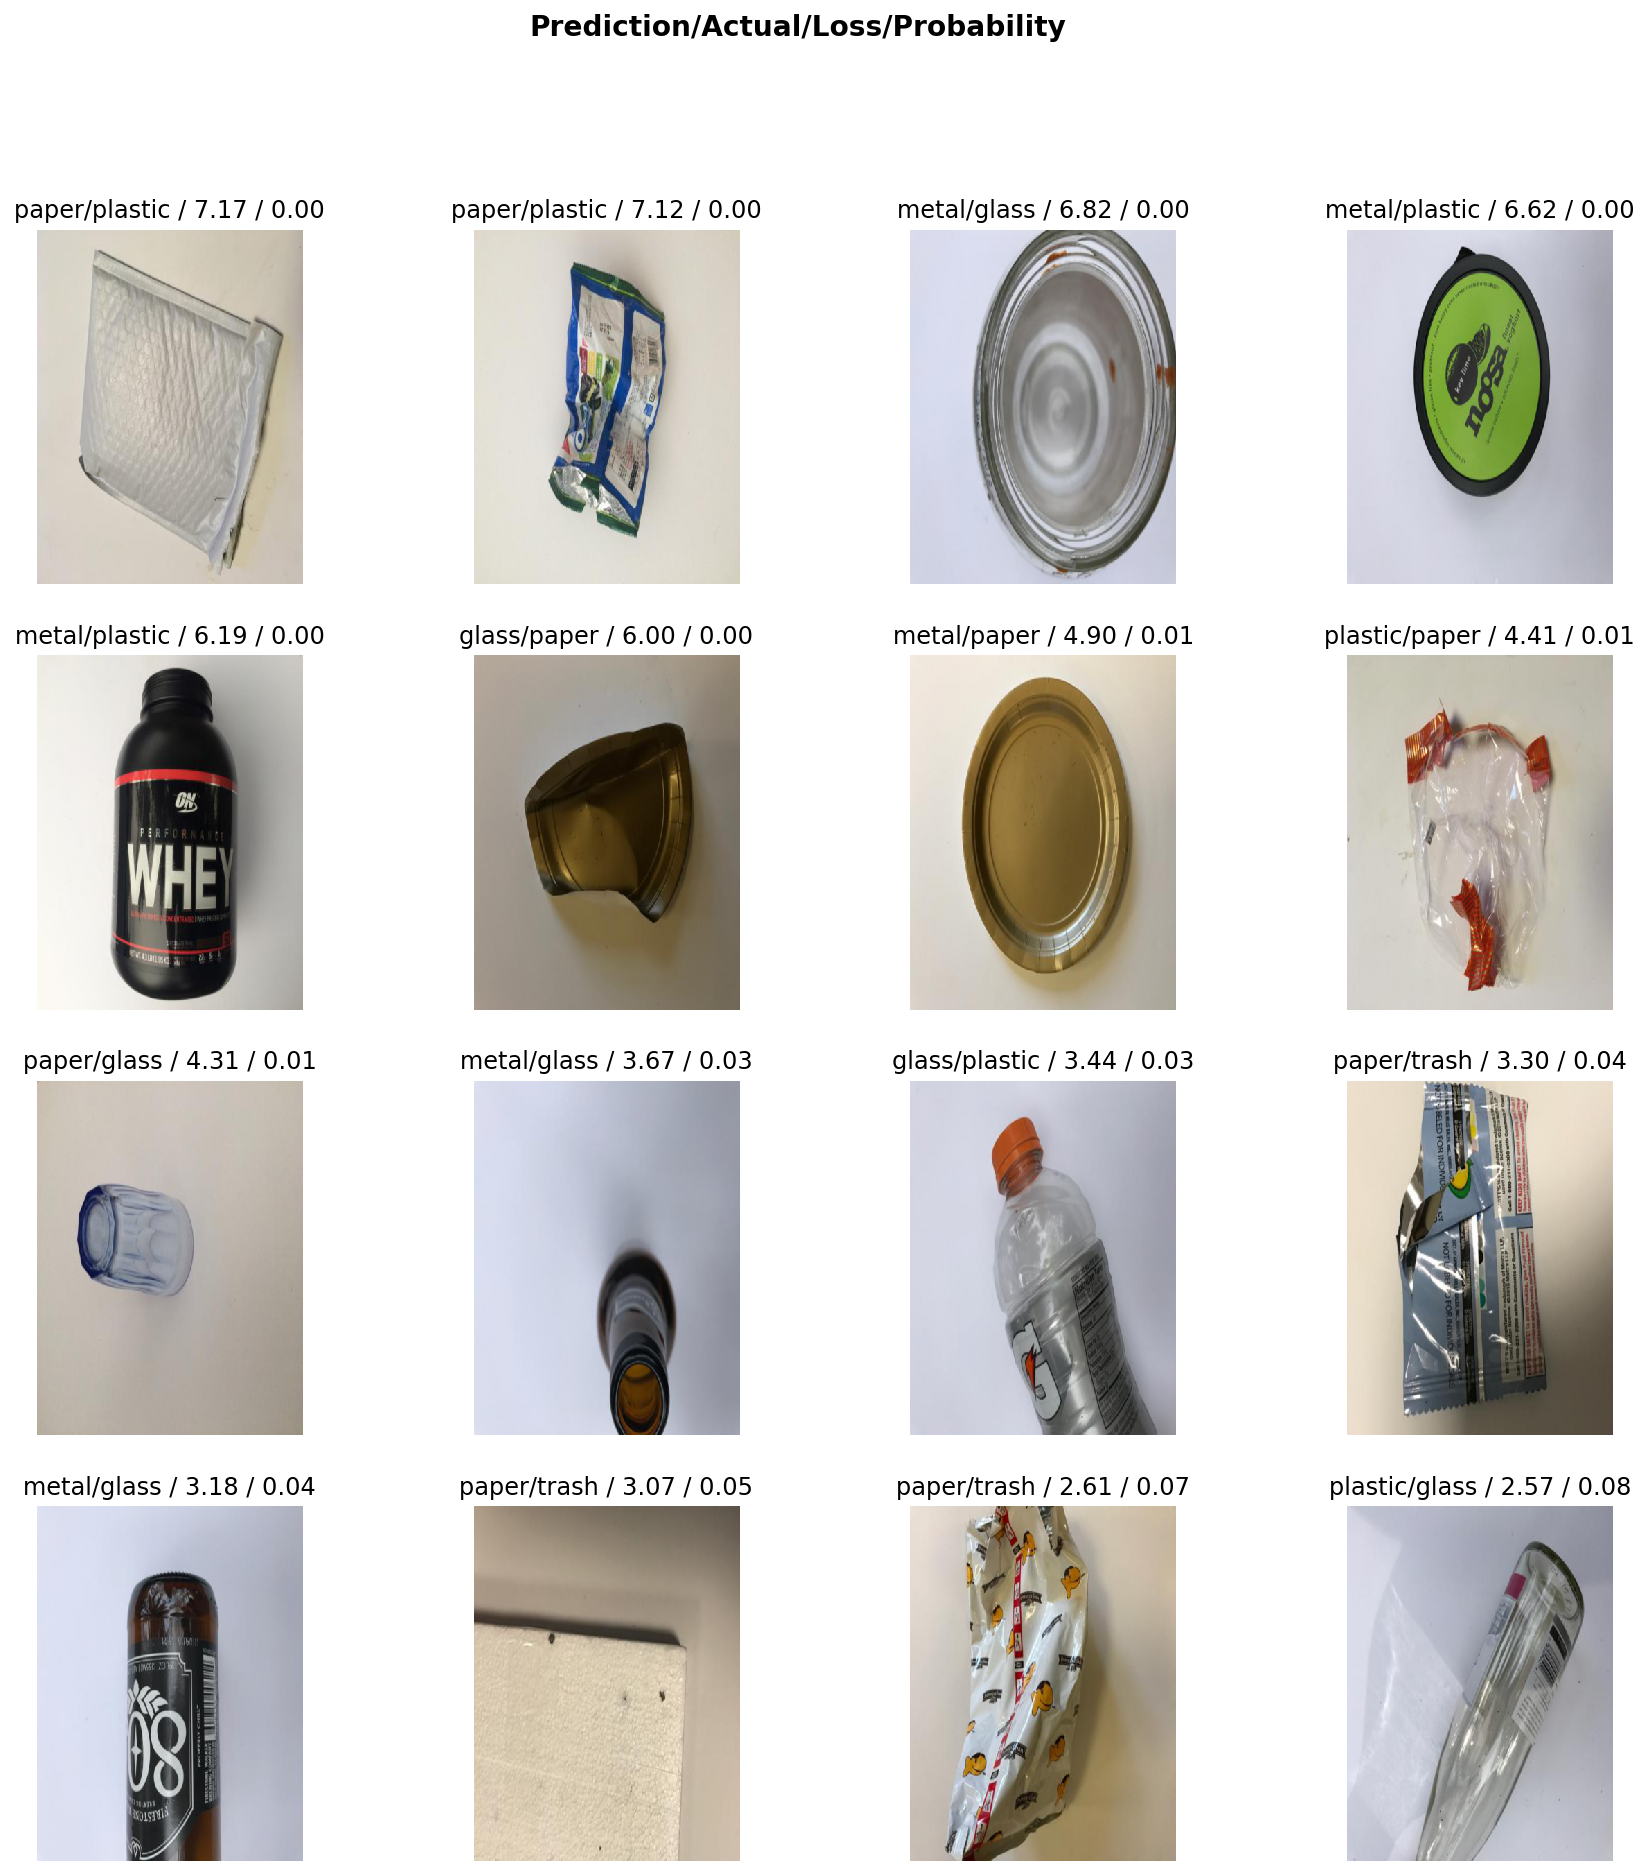

In [155]:
interpolation_data.plot_top_losses(16, heatmap=False, figsize=(15, 15), cmap='gist_earth_r')

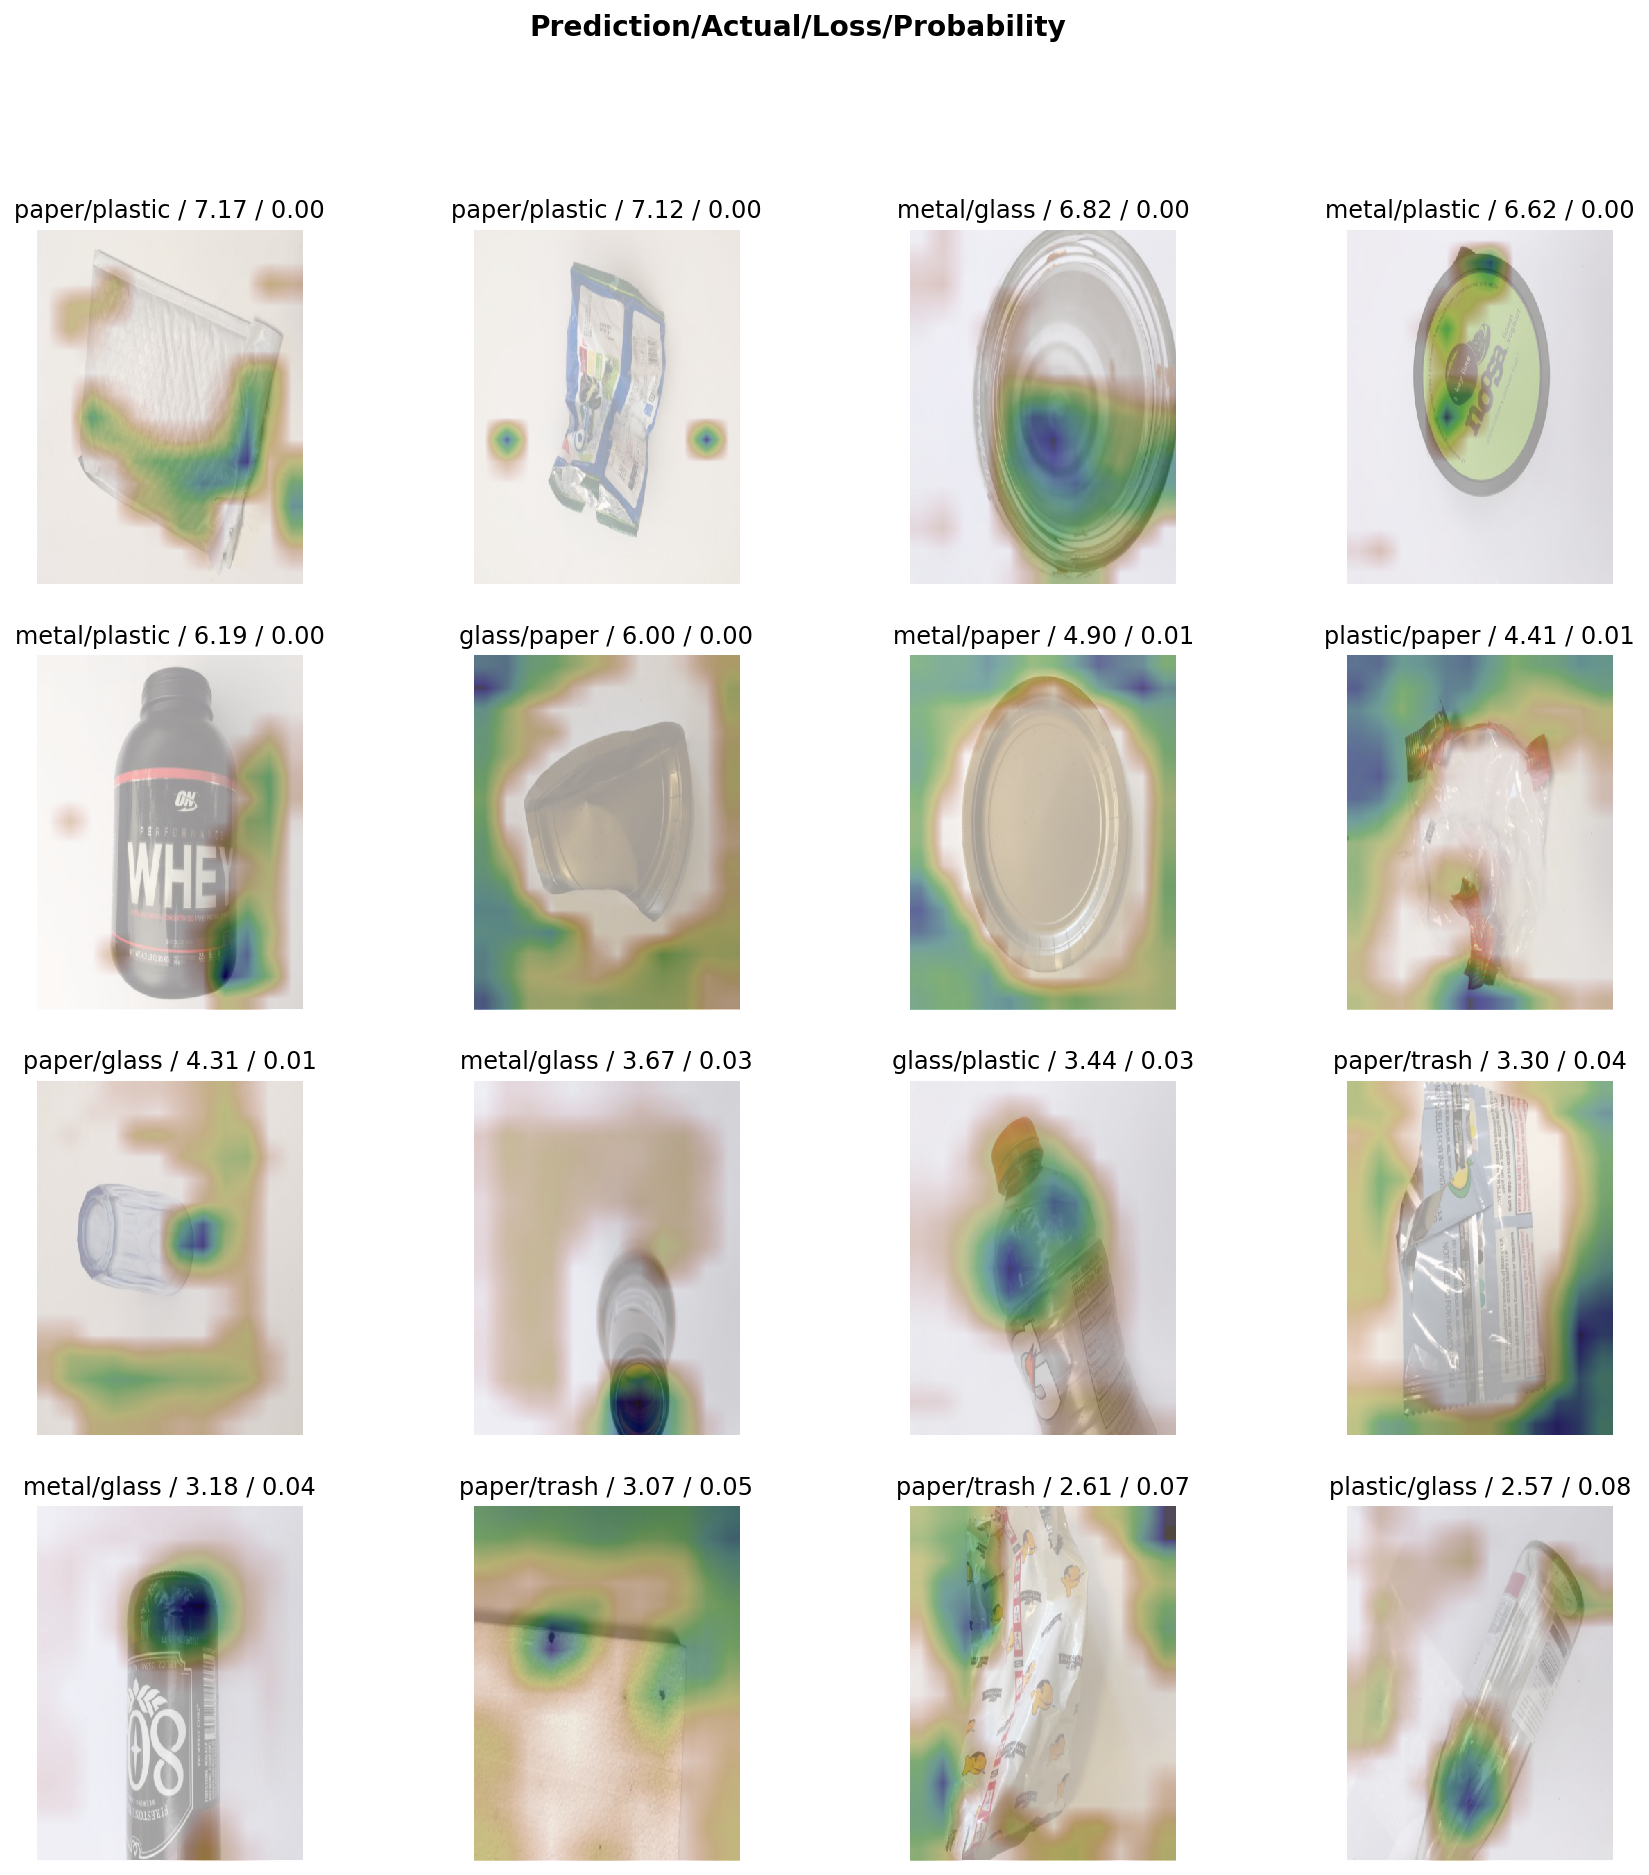

In [156]:
interpolation_data.plot_top_losses(16, heatmap=True, figsize=(15, 15), cmap='gist_earth_r')

## Yayyyy prediction time

In [158]:
data.classes

['cardboard', 'food', 'glass', 'metal', 'paper', 'plastic', 'trash']

Convert probabilities to class labels

In [159]:
predictions = model_learner.get_preds(ds_type=DatasetType.Test)
max_confidence_indices = np.asarray(np.argmax(predictions[0],axis=1))
predicted_labels = []
for max_idx in max_confidence_indices:
    predicted_labels.append(data.classes[max_idx])
predicted_labels

NameError: name 'model_learner' is not defined

Check accuracy since we know the actual labels of 'test'

In [157]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("[a-z]+\/([a-z]+)[0-9]+\.jpg$")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)
    
cm = confusion_matrix(y,predicted_labels)

df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

NameError: name 'predicted_labels' is not defined

In [1]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
accuracy = correct/sum(sum(cm))
accuracy

NameError: name 'cm' is not defined

In [50]:
## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')

# Check for single image

In [5]:
for i in ["chips","bottle","bowl","fork","cup"]:
    pred = model_learner.predict(open_image(f"realtest/"+i+".jpeg"))
    print(i+": "+str(pred))

chips: (Category paper, tensor(4), tensor([0.0147, 0.0049, 0.0140, 0.0488, 0.8298, 0.0035, 0.0844]))
bottle: (Category plastic, tensor(5), tensor([4.8729e-02, 2.0950e-04, 9.3876e-02, 1.0398e-02, 4.0840e-02, 8.0533e-01,
        6.1345e-04]))
bowl: (Category glass, tensor(2), tensor([4.7838e-06, 2.3041e-02, 8.2467e-01, 7.1471e-02, 4.4926e-03, 7.1481e-02,
        4.8418e-03]))
fork: (Category plastic, tensor(5), tensor([4.1539e-05, 4.7827e-05, 1.3171e-01, 1.1177e-01, 2.1894e-02, 7.1780e-01,
        1.6742e-02]))
cup: (Category glass, tensor(2), tensor([1.7682e-04, 1.0228e-04, 9.6875e-01, 4.9812e-03, 2.7844e-03, 2.3193e-02,
        9.5826e-06]))
